## Mimic3 Demo-Ver2

[Mimic3](https://www.kaggle.com/datasets/asjad99/mimiciii) is a large open-access anonymized single-center database which consists of comprehensive clinical data of 61,532 critical care admissions from 2001–2012 collected at a Boston teaching hospital. Dataset consists of 47 features (including demographics, vitals, and lab test results) on a cohort of sepsis patients who meet the sepsis-3 definition criteria.

Due to the privacy concerns, we utilized a subset of he original Mimic3 data that is publicly available on Kaggle. For illustration purpose, we selected several representative features for the following analysis:

*   **Glucose**: glucose values of patients
*   **paO2**: The partial pressure of oxygen
*   **PaO2_FiO2**: The partial pressure of oxygen (PaO2)/fraction of oxygen delivered (FIO2) ratio.
*   **SOFA**: Sepsis-related Organ Failure Assessment score to describe organ dysfunction/failure.
*   **iv-input**: the volumn of fluids that have been administered to the patient.
*   **died_within_48h_of_out_time**:  the mortality status of the patient after 48 hours of being administered.

In the next sections, we will start from causal discovery learning to learn significant causal diagram from the data, and then quantify the effect of treatment ('iv_input') on the outcome (mortality status, denoted by 'died_within_48h_of_out_time' variable in the data) through causal effect learning.

## Causal Discovery Learning

In [1]:
%load_ext autoreload
%autoreload 2

##### Import Packages 
from utils import *
from notear import *
  
from numpy.random import randn
from random import seed as rseed
from numpy.random import seed as npseed

import numpy as np
import pandas as pd
import os
import pickle
import random
import math
import time 

from datetime import datetime

import matplotlib.pyplot as plt

from multiprocessing import Pool
 
from tqdm import tqdm
from functools import partial 

os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
mimic3_data = pd.read_csv('mimic3_single_stage.csv')
mimic3_data.iloc[np.where(mimic3_data['Died within 48H']==-1.0)[0],5]=0 # change the discrete action to binary

In [3]:
mimic3_data.head(6)

,icustayid,Glucose,PaO2,PaO2_FiO2,IV Input,SOFA,Died within 48H
0,1006,152.000000,100.200000,137.081590,2.800000,0.000000,-1.0
1,1204,138.794872,127.782051,430.668956,1.153846,6.153846,1.0
2,4132,129.364286,123.956461,252.883864,3.000000,0.000000,-1.0
3,4201,145.580087,118.083333,539.065657,1.363636,5.818182,1.0
4,5170,174.525000,147.350198,394.616727,2.437500,4.125000,1.0
5,6504,106.081169,88.836364,423.030303,0.363636,5.090909,1.0


In [4]:
# ----------- Estimated DAG based on NOTEARS 

mimic3_data_final = mimic3_data  

selected = ['Glucose', 'PaO2_FiO2', 'IV Input', 'SOFA', 'SOFA Post', 'Died within 48H']

sample_demo = mimic3_data_final[selected]
est_mt = notears_linear(np.array(sample_demo), lambda1=0, loss_type='l2',w_threshold=0.1)
 
# ----------- Refit Associated Matrix under LSEM 

est_mt, _ = refit(sample_demo, est_mt, selected) 

KeyError: "['SOFA Post'] not in index"

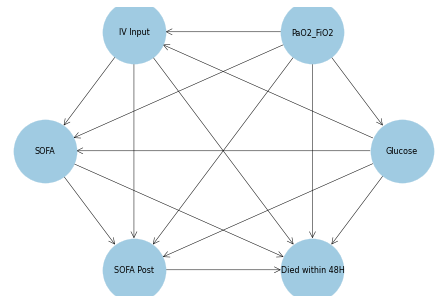

In [5]:
# ----------- Plot Associated Estimated DAG based on NOTEARS 

plot_net(est_mt, labels_name=selected, file_name='demo_res_net')


In [6]:
topo_list = np.array(selected)[list(nx.topological_sort(nx.DiGraph(est_mt)))].tolist()
topo_list.reverse()
print('Topological order from top to buttom:\n', topo_list)

Topological order from top to buttom:
 ['PaO2_FiO2', 'Glucose', 'IV Input', 'SOFA', 'SOFA Post', 'Died within 48H']


## Causal Effect Learning

According to the amount of fluid administraition throughout the entire treatment period, we plot the average IV input for each patient as below:

(array([9., 2., 7., 7., 1., 9., 8., 5., 4., 5.]),
 array([0.        , 0.35384615, 0.70769231, 1.06153846, 1.41538462,
        1.76923077, 2.12307692, 2.47692308, 2.83076923, 3.18461538,
        3.53846154]),
 <BarContainer object of 10 artists>)

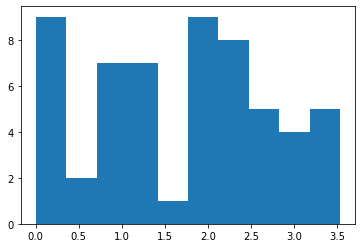

In [7]:
plt.hist(mimic3_data['IV Input'])

As we can see from the histogram above, there is a small gap when the average IV Input is around $1.5$. This gap naturally split the data into two treatment groups: "High-IV-Input" group and "Low-IV-Input" group. We are interested in whether the highe level fluid intake treatment is able to decrease the SOFA score and the death rate of patients within 48 hours of administration.

Motivated by this problem, we set the "High-IV-Input" group as the treatment group with $A=1$, and set the "Low-IV-Input" group as the control group with $A=0$. 

In [8]:
data_CEL_selected = mimic3_data.copy()
data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']<=1.5)[0],3]=0 # change the discrete action to binary
data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']>1.5)[0],3]=1 # change the discrete action to binary

data_CEL_selected.head(6)

,icustayid,Glucose,PaO2_FiO2,IV Input,SOFA,Died within 48H,SOFA Post
0,1006,152.000000,137.081590,1.0,8.400000,0.0,7.600000
1,1204,138.794872,430.668956,0.0,5.692308,1.0,6.153846
2,4132,129.364286,252.883864,1.0,4.800000,0.0,4.600000
3,4201,145.580087,539.065657,0.0,5.636364,1.0,5.818182
4,5170,174.525000,394.616727,1.0,3.625000,1.0,4.125000
5,6504,106.081169,423.030303,0.0,6.000000,1.0,5.090909


In [9]:
print( "The number of patients in treatment group is ", len(np.where(mimic3_data['IV Input']>1.5)[0]), ";\n", "The number of patients in control group is ", len(np.where(mimic3_data['IV Input']<=1.5)[0]),".")

The number of patients in treatment group is  32 ;
 The number of patients in control group is  25 .


### Regard 'Died_Within_48H' as the outcome variable

In [10]:
userinfo_index = np.array([1,2])
# outcome: Died within 48H (binary)
# treatment: IV Input (binary)
# Glucose, PaO2_FiO2: covariates

In [11]:
print(np.sum(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==0)[0],5] == 1))
print(np.sum(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==0)[0],5] == 0))
print(np.sum(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==1)[0],5] == 1))
print(np.sum(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==1)[0],5] == 0))

24
1
24
8


In [12]:
#from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

#mu0 = GradientBoostingClassifier(max_depth=2)
#mu1 = GradientBoostingClassifier(max_depth=2)

mu0 = LogisticRegression()
mu1 = LogisticRegression()

mu0.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==0)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==0)[0],5] )
mu1.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==1)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==1)[0],5] )


# estimate the HTE by T-learner
HTE_T_learner = (mu1.predict_proba(data_CEL_selected.iloc[:,userinfo_index]) - mu0.predict_proba(data_CEL_selected.iloc[:,userinfo_index]))[:,1]

In [13]:
HTE_T_learner

array([ 0.45322357, -0.12551825, -0.31095315, -0.06658004, -0.14936954,
       -0.13404695, -0.32144405, -0.41540906, -0.11657287, -0.0605553 ,
       -0.41204992, -0.350003  , -0.07587157, -0.1937542 , -0.29406602,
       -0.27231197, -0.44362365, -0.08949383, -0.4349184 , -0.13355717,
       -0.16845723, -0.0938565 , -0.30817118, -0.06978495,  0.50736663,
       -0.20295236, -0.17239035, -0.27745005, -0.2927717 , -0.31615833,
       -0.3621005 , -0.19816815, -0.29745249, -0.31014128, -0.00821821,
       -0.19483265, -0.16912685, -0.20077837, -0.37305844, -0.24538905,
       -0.20552501, -0.38095327, -0.38948743, -0.2780394 , -0.11502808,
       -0.45806054, -0.29489358, -0.18854476, -0.06531642, -0.22022294,
       -0.22806464, -0.31916684, -0.05725299, -0.37429873, -0.16776177,
       -0.30377136, -0.44658451])

As we can see from the estimated treatment effect of each patient, a higher volumn of fluid intake is inclined to cause negative impact on patients' health status. This may seem counterintuitive to us, which may indicates some selection bias within this small dataset. Despite so, this result also remind us to pay attention to the potentially unnecessary fluid intake that may increase the death rate of patients.

In [14]:
np.where(mu1.predict(data_CEL_selected.iloc[:,userinfo_index])-mu0.predict(data_CEL_selected.iloc[:,userinfo_index])==1)[0]

array([ 0, 24], dtype=int64)

Although it generally might be harmful to patients to take fluids, Patient # {0, 24} is expected to be the surviver after the fluid intake.

In [15]:
sum(HTE_T_learner)/len(data_CEL_selected)

-0.21392525739350662

Overall, IV Input is expected to increase the death-within-48-hours rate of all patients by 21.39%.

### Regard 'SOFA' as the outcome variable

In [16]:
userinfo_index = np.array([1,2])
# outcome: SOFA score (treated as continuous). The smaller, the better
# treatment: iv_input (binary)
# Glucose, PaO2_FiO2: covariates
data_CEL_selected.head(6)

,icustayid,Glucose,PaO2_FiO2,IV Input,SOFA,Died within 48H,SOFA Post
0,1006,152.000000,137.081590,1.0,8.400000,0.0,7.600000
1,1204,138.794872,430.668956,0.0,5.692308,1.0,6.153846
2,4132,129.364286,252.883864,1.0,4.800000,0.0,4.600000
3,4201,145.580087,539.065657,0.0,5.636364,1.0,5.818182
4,5170,174.525000,394.616727,1.0,3.625000,1.0,4.125000
5,6504,106.081169,423.030303,0.0,6.000000,1.0,5.090909


Similarly, we estimate the causal effect of fluid administration on the average SOFA score of patients to see if higher IV input is able to decrease the SOFA score.

In [17]:
#from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

#mu0 = LGBMRegressor(max_depth=2)
#mu1 = LGBMRegressor(max_depth=2)

mu0 = LinearRegression()
mu1 = LinearRegression()

mu0.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==0)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==0)[0],4] )
mu1.fit(data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==1)[0],userinfo_index],data_CEL_selected.iloc[np.where(data_CEL_selected['IV Input']==1)[0],4] )


# estimate the HTE by T-learner
HTE_T_learner = (mu1.predict(data_CEL_selected.iloc[:,userinfo_index]) - mu0.predict(data_CEL_selected.iloc[:,userinfo_index]))

In [18]:
HTE_T_learner

array([ 0.33471421,  0.58750923,  0.69769602,  0.50468707,  0.04119141,
        1.08032529,  0.24677671, -0.46879497,  1.14228685,  0.40913012,
       -0.26967209, -2.10424795, -0.15469547,  0.86680554,  1.01699509,
        0.50534554,  0.50120394,  0.0832772 ,  0.4053538 ,  0.61938348,
        0.63167011,  0.53840976,  1.10602297,  1.04338229, -0.18159866,
        0.77996324,  0.7988097 ,  0.94550731,  1.28227784,  0.9895861 ,
        0.34582444,  0.63707457,  0.67745798,  1.16396444,  0.3173255 ,
        0.41720785, -1.66927895,  0.09861153, -0.9408872 ,  1.21402004,
        0.85013445,  0.61804279,  0.67352783, -0.06219661,  0.78217875,
        0.87809129,  0.81120382,  0.61344813,  0.6384825 , -0.26478542,
        0.95845848,  1.14744284,  0.86349984,  0.74704598,  0.2168899 ,
       -0.97526792,  0.68596023])

Although for some patients, higher volumn of fluid intake is able to decrease their overall SOFA score, most of the rest of the patients suffered some bad effects from it.

In [19]:
sum(HTE_T_learner)/len(data_CEL_selected)

0.4460136626503026

**Conclusion**: IV Input is expected to increase the SOFA score by 0.446.